# ETM595 Project
#### Uğurhan Aksu

## Table of Contents
1. Introduction
    * 1.1 The Data
    * 1.2 Covariances of the Assets
    * 1.3 Statistics
2. Example portfolios
    * 2.1 Example Portfolio Weigths
    * 2.2 Example Portfolio Statistics
	* 2.3 Example Portfolio Probabilities
3. Markowitz Model Application
	* 3.1 Markowitz model
    * 3.2 Standard Deviation - Return Diagram
        * 3.2.1 Simulation Metholodogy
        * 3.2.2 Efficient Frontier, Shorting Not Allowed
        * 3.2.3 Efficient Frontier, Shorting Allowed
	* 3.3 Solutions
        * 3.3.1 Shorting Not Allowed, Quadratic Solution
        * 3.3.2 Shorting Allowed, Algebraic Solution
    * 3.4 Comparison of Solutions
4. One-fund theorem
	* 4.1 Algebraic Model
	* 4.2 Expected Return
	* 4.3 Probabilities
5. CAPM Model
    * 5.1 Assumed Market Portfolio
        * 5.1.1 Capital Market Line
        * 5.1.2 Price of Risk
        * 5.1.3 Beta Values
        * 5.1.4 Security Market Line
    * 5.2 S&P500 Index as the Market Portfolio
        * 5.2.1 S&P500 Data
        * 5.2.2 Capital Market Line
        * 5.2.3 Beta Values
        * 5.2.4 Security Market Line
        * 5.2.5 Jensen Index Evaluation
        * 5.2.6 Sharpe Index Evaluation
    * 5.3 Portfolio Evaluation

## 1. Introduction

Required packages for data processing are listed below

In [1]:
import pandas as pd
import numpy as np
import os
from scipy.optimize import minimize
import scipy.stats as st
import numpy as np, numpy.random
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler


### 1.1 The Data

SP&500 data is scraped from marketwatch website. Following function can be employed for dynamic data processing. However dates of the obtained data must be double checked because web scraping is not as reliable as API usage. Following function is used once and the analysis is conducted with static data within the below defined intervals due to report coherence.

In [2]:
'''
def getStockData(stockKey, dataKey):
    #Data Keys : Date, Open, High, Low, Close, Volume

    #stockKey = "AAPL"
    periodStart = "08/07/2021"
    periodEnd = "12/10/2021"


    url = ("https://www.marketwatch.com/investing/stock/{}/downloaddatapartial?startdate={}00:00:00"+\
    "&enddate={}00:00:00"+\
    "&daterange=m6"+\
    "&frequency=p1d"+\
    "&csvdownload=true"+\
    "&downloadpartial=false&newdates=false").format(
        stockKey,
        periodStart,
        periodEnd
        )

    #access whole data
    #stockData = pd.read_csv( url )

    return pd.read_csv( url )[dataKey]
'''




'\ndef getStockData(stockKey, dataKey):\n    #Data Keys : Date, Open, High, Low, Close, Volume\n\n    #stockKey = "AAPL"\n    periodStart = "08/07/2021"\n    periodEnd = "12/10/2021"\n\n\n    url = ("https://www.marketwatch.com/investing/stock/{}/downloaddatapartial?startdate={}00:00:00"+    "&enddate={}00:00:00"+    "&daterange=m6"+    "&frequency=p1d"+    "&csvdownload=true"+    "&downloadpartial=false&newdates=false").format(\n        stockKey,\n        periodStart,\n        periodEnd\n        )\n\n    #access whole data\n    #stockData = pd.read_csv( url )\n\n    return pd.read_csv( url )[dataKey]\n'

Some of the data imported are of objec data type. To conduct numerical analysis, object data type is casted to numeric formats by the function below

In [3]:

def objectToInt( target ):
    #decimal part
    if str.find(target,".") > 0:
         dec = str.split(target,".")[1]
    else:
        dec = ""
    #main part
    main = ""
    for i in str.split( str.split(target,".")[0], "," ):
        main += i
    
    return int(main+dec)/10**len(dec)
    

The stocks mentioned in the cell below are used in the analysis. For report coherence, static data of above defined intervals are used. Data type of fields can be seen as the output.

In [4]:
stockList = [
    "AAPL", "MSFT", "AMZN", "GOOGL", "FB",
    "TSLA", "NVDA", "ADBE", "NFLX", "CRM",
    "CSCO", "QCOM", "INTC", "VZ", "T"
]

'''
errorFlag = 0
closeData = pd.DataFrame()
for stock in stockList:

    #gets the date
    try:
        closeData["Date"]
    except:
        closeData["Date"] = getStockData(stockList[0], "Date")
    
    #gets the stock close value
    try:
        temp = getStockData(stock, "Close")

        #Some data are not of number format
        if temp.dtype == "O":
            closeData[stock] = temp.apply( objectToInt )
        else:
            closeData[stock] = temp

    except:
        errorFlag = 1
    
    if errorFlag == 1:
        print("Error at extracting stock,",stock)
        break
    
if errorFlag == 0:
    print("All data extracted succesfully")
'''
#Saves to desktop
#closeData.to_excel( os.path.expanduser("~/Desktop/") + "stockClose.xlsx" )

closeData = pd.read_excel( os.path.expanduser("~/Desktop/Belgeler/BOUN/Dersler/ETM595 RISK/PJ/Solo/stockClose.xlsx") )
del closeData["Unnamed: 0"]
closeData.dtypes

Date      object
AAPL     float64
MSFT     float64
AMZN     float64
GOOGL    float64
FB       float64
TSLA     float64
NVDA     float64
ADBE     float64
NFLX     float64
CRM      float64
CSCO     float64
QCOM     float64
INTC     float64
VZ       float64
T        float64
dtype: object

Stock closing values of each given date in the first column are obtained and aggregated, data format is represented below by providing first 10 rows.

In [5]:
closeData.head(10)

,Date,AAPL,MSFT,AMZN,GOOGL,FB,TSLA,NVDA,ADBE,NFLX,CRM,CSCO,QCOM,INTC,VZ,T
0,12/10/2021,179.45,342.54,3444.24,2960.03,329.75,1017.03,301.98,654.45,611.66,266.03,59.25,183.88,50.59,50.19,22.84
1,12/09/2021,174.56,333.10,3483.42,2952.77,329.82,1003.80,304.90,632.57,611.00,264.32,57.55,182.26,50.48,50.16,22.94
2,12/08/2021,175.08,334.97,3523.16,2963.73,330.56,1068.96,318.26,653.10,628.08,266.31,57.02,182.63,51.75,50.49,23.17
3,12/07/2021,171.18,334.92,3523.29,2945.39,322.81,1051.75,324.27,649.96,625.58,266.99,58.08,183.72,52.57,50.79,23.08
4,12/06/2021,165.32,326.19,3427.37,2863.10,317.87,1009.01,300.37,622.04,612.69,258.75,56.96,175.45,50.99,51.07,23.28
5,12/03/2021,161.84,323.01,3389.79,2840.03,306.84,1014.97,306.93,616.53,602.13,258.32,56.23,176.51,49.25,51.42,23.46
6,12/02/2021,163.76,329.49,3437.36,2859.32,310.39,1084.60,321.26,671.88,616.47,261.20,56.15,177.03,49.50,50.73,23.05
7,12/01/2021,164.77,330.08,3443.72,2821.03,310.60,1095.00,314.35,657.41,617.77,251.50,55.03,175.63,48.60,49.77,22.23
8,11/30/2021,165.30,330.59,3507.07,2837.95,324.46,1144.76,326.76,669.85,641.90,284.96,54.84,180.56,49.20,50.27,22.83
9,11/29/2021,160.24,336.63,3561.57,2910.61,338.03,1136.99,333.76,687.49,663.84,296.74,55.76,183.74,50.00,51.66,23.89


By using stock close values, each individual daily change rates are calculated by dividing the change amount to previous day. First ten rows of the obtained data format are displayed.

In [6]:
changeData = pd.DataFrame()
for col in closeData.columns.values:
    if col == "Date":
        changeData[col] = closeData.iloc[ :closeData.shape[0]-1, np.where(closeData.columns.values == [col])[0][0] ]
    else:
        changeList = []
        for row in range(closeData.shape[0]-1):
            #change value at t represents value(t) - value(t-1)
            changeList.append( (closeData.loc[row,col] - closeData.loc[row+1,col])/closeData.loc[row+1,col] )
            
        changeData[col] = changeList

        
changeData.head()
#changeData.to_excel( os.path.expanduser("~/Desktop/") + "changeData.xlsx" )

,Date,AAPL,MSFT,AMZN,GOOGL,FB,TSLA,NVDA,ADBE,NFLX,CRM,CSCO,QCOM,INTC,VZ,T
0,12/10/2021,0.028013,0.028340,-0.011248,0.002459,-0.000212,0.013180,-0.009577,0.034589,0.001080,0.006469,0.029540,0.008888,0.002179,0.000598,-0.004359
1,12/09/2021,-0.002970,-0.005583,-0.011280,-0.003698,-0.002239,-0.060956,-0.041978,-0.031435,-0.027194,-0.007472,0.009295,-0.002026,-0.024541,-0.006536,-0.009927
2,12/08/2021,0.022783,0.000149,-0.000037,0.006227,0.024008,0.016363,-0.018534,0.004831,0.003996,-0.002547,-0.018251,-0.005933,-0.015598,-0.005907,0.003899
3,12/07/2021,0.035446,0.026764,0.027986,0.028742,0.015541,0.042358,0.079569,0.044885,0.021038,0.031845,0.019663,0.047136,0.030986,-0.005483,-0.008591
4,12/06/2021,0.021503,0.009845,0.011086,0.008123,0.035947,-0.005872,-0.021373,0.008937,0.017538,0.001665,0.012982,-0.006005,0.035330,-0.006807,-0.007673


For the analysis, ninety most recent dates are used by shrinking the data.

In [7]:
#shrinking data to 90 points
closeData = closeData.iloc[:90,:]
changeData = changeData.iloc[:90,:]
closeData.index.rename("Period", inplace=True)
changeData.index.rename("Period", inplace=True)

### 1.2 Covariances of the Assets

In [8]:
covariance_matrix= changeData.cov()
covariance_matrix

,AAPL,MSFT,AMZN,GOOGL,FB,TSLA,NVDA,ADBE,NFLX,CRM,CSCO,QCOM,INTC,VZ,T
AAPL,0.000189,9.452891e-05,0.000109,0.000093,0.000095,0.000095,0.000159,0.000119,0.000051,0.000052,0.000045,0.000099,0.000063,-0.000007,2.060449e-06
MSFT,0.000095,1.570478e-04,0.000085,0.000138,0.000098,0.000077,0.000205,0.000157,0.000083,0.000098,0.000065,0.000103,0.000073,0.000003,-8.385666e-07
AMZN,0.000109,8.477681e-05,0.000200,0.000125,0.000114,0.000047,0.000254,0.000127,0.000067,0.000108,0.000007,0.000164,0.000092,-0.000005,4.848624e-06
GOOGL,0.000093,1.376593e-04,0.000125,0.000192,0.000124,0.000043,0.000213,0.000133,0.000063,0.000108,0.000060,0.000121,0.000116,0.000008,1.263322e-05
FB,0.000095,9.763278e-05,0.000114,0.000124,0.000323,0.000136,0.000177,0.000169,0.000105,0.000153,0.000042,0.000142,0.000163,0.000009,3.853273e-05
TSLA,0.000095,7.705742e-05,0.000047,0.000043,0.000136,0.000974,0.000250,0.000168,0.000085,0.000159,-0.000023,0.000122,0.000097,-0.000030,2.404308e-05
NVDA,0.000159,2.052804e-04,0.000254,0.000213,0.000177,0.000250,0.000875,0.000340,0.000145,0.000278,0.000038,0.000411,0.000137,-0.000023,-3.337166e-05
ADBE,0.000119,1.570928e-04,0.000127,0.000133,0.000169,0.000168,0.000340,0.000348,0.000138,0.000184,0.000063,0.000176,0.000082,-0.000013,-1.974114e-05
NFLX,0.000051,8.343183e-05,0.000067,0.000063,0.000105,0.000085,0.000145,0.000138,0.000291,0.000130,0.000018,0.000014,0.000041,0.000003,1.282269e-05
CRM,0.000052,9.808506e-05,0.000108,0.000108,0.000153,0.000159,0.000278,0.000184,0.000130,0.000423,0.000064,0.000168,0.000068,0.000019,4.293428e-05


### 1.3 Statistics

In [9]:
data_statistics = changeData.describe()
data_statistics

,AAPL,MSFT,AMZN,GOOGL,FB,TSLA,NVDA,ADBE,NFLX,CRM,CSCO,QCOM,INTC,VZ,T
count,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000
mean,0.002316,0.002064,0.000391,0.001107,-0.000780,0.004469,0.004860,0.000674,0.002006,0.001167,0.000772,0.002631,-0.000549,-0.001060,-0.002137
std,0.013744,0.012532,0.014129,0.013844,0.017969,0.031205,0.029588,0.018650,0.017063,0.020569,0.012972,0.022078,0.017359,0.007926,0.011383
min,-0.033102,-0.036204,-0.030842,-0.037158,-0.050515,-0.119903,-0.048693,-0.082381,-0.037592,-0.117420,-0.055144,-0.041622,-0.116786,-0.026907,-0.044370
25%,-0.005546,-0.005009,-0.007115,-0.005516,-0.010563,-0.006623,-0.012851,-0.006708,-0.008187,-0.007394,-0.005218,-0.007131,-0.007442,-0.006256,-0.009082
50%,0.002221,0.000817,-0.000289,0.001983,0.000722,0.005021,0.001377,0.001673,0.002669,0.000838,0.000513,-0.001454,0.000092,-0.001005,-0.002371
75%,0.009620,0.009936,0.010053,0.008697,0.011294,0.018694,0.019809,0.011065,0.011157,0.011020,0.007870,0.008659,0.008793,0.003487,0.004028
max,0.035446,0.042114,0.041437,0.049595,0.040123,0.126616,0.120423,0.044885,0.052142,0.072115,0.038441,0.127311,0.035330,0.024069,0.036887


## 2. Example Portfolios

### 2.1 Portfolio Weigths

Two example portfolios are established without considering optimality. Weight of assets in one of the portfolios are proportional to the mean returns and the other one is inversely proportional to variances of the individual assets. Weigths of assets are consolidated with mean and variance data of the individual assets and displayed as a whole. Since some of the assets yielded negative mean returns in the predefined period, mean-proportional weigthed portfolio suggests short selling of some of the assets.

In [10]:
weigths_mp = []
weigths_ivp = []
for i in data_statistics.columns.values:
    
    #Weigths of mean proportional portfolio
    weigths_mp.append(data_statistics.loc["mean",i] / sum(data_statistics.loc["mean",:].values))
    
    #Weigths of inverse variance proportional portfolio
    weigths_ivp.append( (1/data_statistics.loc["std",i])/sum(1/data_statistics.loc["std",:].values) )
    
    
example_portfolios = pd.DataFrame({
    "Mean":list( data_statistics.loc["mean",:].values ),
    "Variance": list( data_statistics.loc["std",:].values**2 ),
    "Weigths, Mean":weigths_mp,
    "Weigths, Inverse Variance":weigths_ivp
}).T

for i in range (len(example_portfolios.columns.values)):
    example_portfolios.rename( columns={ example_portfolios.columns.values[i] : data_statistics.columns.values[i] },
                              inplace=True)
example_portfolios


,AAPL,MSFT,AMZN,GOOGL,FB,TSLA,NVDA,ADBE,NFLX,CRM,CSCO,QCOM,INTC,VZ,T
Mean,0.002316,0.002064,0.000391,0.001107,-0.000780,0.004469,0.004860,0.000674,0.002006,0.001167,0.000772,0.002631,-0.000549,-0.001060,-0.002137
Variance,0.000189,0.000157,0.000200,0.000192,0.000323,0.000974,0.000875,0.000348,0.000291,0.000423,0.000168,0.000487,0.000301,0.000063,0.000130
"Weigths, Mean",0.129153,0.115111,0.021821,0.061714,-0.043521,0.249235,0.271052,0.037574,0.111862,0.065106,0.043065,0.146712,-0.030612,-0.059097,-0.119175
"Weigths, Inverse Variance",0.074864,0.082103,0.072822,0.074322,0.057258,0.032973,0.034775,0.055170,0.060301,0.050021,0.079316,0.046603,0.059273,0.129811,0.090387


### 2.2 Example Portfolio Statistics
$$ \frac{1}{2} \sum_{i,j=1}^{n}w_{i}w_{j}σ_{ij} $$ 
$$ \sum_{i=1}^{n}w_{i}ṝ_{i} = ṝ $$

Expected returns and variances of the portfolios are calculated with respect to the given formulas. It is naturally observed that mean-proportional portfolio is superior in terms of expected return. However, inverse variance proportional portfolio possesses lesser risk.

In [11]:
# mean proportional mp, inverse variance proportional ivp
mp_variance = 0
ivp_variance = 0
for i in covariance_matrix.columns.values:
    for ii in covariance_matrix.columns.values:
        mp_variance = mp_variance + covariance_matrix.loc[i,ii]*example_portfolios.loc["Weigths, Mean",i]*example_portfolios.loc["Weigths, Mean",ii]
        ivp_variance = ivp_variance + covariance_matrix.loc[i,ii]*example_portfolios.loc["Weigths, Inverse Variance",i]*example_portfolios.loc["Weigths, Inverse Variance",ii]
print("Mean-proportional portfolio variance: ", mp_variance)
print("Inverse variance proportional porfolio variance: ", ivp_variance)

mp_daily_return = 0
ivp_daily_return = 0 
for i in covariance_matrix.columns.values:
    mp_daily_return = mp_daily_return + example_portfolios.loc["Weigths, Mean",i]*example_portfolios.loc["Mean",i]
    ivp_daily_return = ivp_daily_return + example_portfolios.loc["Weigths, Inverse Variance",i]*example_portfolios.loc["Mean",i]
print("Mean-proportional portfolio weekly return:  %"+ str(100*5*mp_daily_return))
print("Inverse variance proportional porfolio weekly return:  %"+ str(100*5*ivp_daily_return))


Mean-proportional portfolio variance:  0.00033421025785638326
Inverse variance proportional porfolio variance:  7.839291244506904e-05
Mean-proportional portfolio weekly return:  %2.0787913835143095
Inverse variance proportional porfolio weekly return:  %0.3811792711027852


### 2.3 Example Portfolio Probabilities


$$ z = \frac{x-µ}{σ}$$

Weekly inflation is calculated by dividing US yearly inflation into 52 weeks. Since number of data points are far greater than 30, probability calculations are done by standard normal approximation. Even with the recent spikes in US inflation, both of the example portfolios are certainly beating the inflation. This is very common to observe in US economy since the treasury rates and inflations are usually stable and low after 1980s. Expected returns of example portfolios are greater than the inflation, division of such values by small variances yield absurdly low Z values.

In [12]:
weekly_inflation = (0.062/52)
print("Weekly inflation: %", 100*weekly_inflation)

mp_zScore = (weekly_inflation-5*mp_daily_return)/mp_variance
ivp_zScore = (weekly_inflation-5*ivp_daily_return)/ivp_variance
print("mp z-score: ", mp_zScore)
print("ivp z-score: ", ivp_zScore)


print("mp portfolio will outperform inflation with p-value: ",1- st.norm.cdf( mp_zScore ))
print("ivp portfolio will outperform inflation with p-value: ",1- st.norm.cdf( ivp_zScore ))

Weekly inflation: % 0.11923076923076924
mp z-score:  -58.632569414598926
ivp z-score:  -33.41481949092871
mp portfolio will outperform inflation with p-value:  1.0
ivp portfolio will outperform inflation with p-value:  1.0


## 3. Markowitz Model Application

### 3.1 Markowitz Model

$$ \frac{1}{2} \sum_{i,j=1}^{n}w_{i}w_{j}σ_{ij} $$ 

$$ \sum_{i=1}^{n}w_{i}ṝ_{i} = ṝ $$
 
$$ \sum_{i=1}^{n}w_{i} = 1 $$


Markowitz Model's equations are written as functions to enable repetitive usage. Since the derivation of the objective function is not being calculated by hand, 1/2 multiplier is omitted. This will enable utilization of this function to obtain variance values directly throughout the analysis. Constraint 1 directly calculates return of the portfolios of given weights. As for the Constraint 2, 1 constant is moved inside the equation to result 0 when the constraint is satisfied, this is an obligation for the utilized optimization package.

In [13]:
initial_weigths = list(example_portfolios.loc["Weigths, Mean",:].values)
def objective_ns(initial_weigths):
    var = 0
    for i in range (len(example_portfolios.loc["Weigths, Mean",:].values)):
        for ii in range (len(example_portfolios.loc["Weigths, Mean",:].values)):
            var += covariance_matrix.iloc[i,ii]*initial_weigths[i]*initial_weigths[ii]
    return var

def constraint1_ns(initial_weigths):
    mean_returns = example_portfolios.iloc[0,:].values
    daily_return = 0
    for i in range( len(initial_weigths) ):
        daily_return = daily_return + initial_weigths[i]*mean_returns[i]
    return daily_return
    

def constraint2_ns(initial_weigths):
    return (1-np.sum(initial_weigths))


## 3.2 Standard Deviation - Return Diagram

### 3.2.1 Simulation Metholodogy

In order to obtain Standard deviation - Return diagram, simulation is performed. Random feasible inputs that are obeying standard normal distribution are generated within the boundaries. Then inputs are scaled to [0,1], [-1,1] for no-shorting allowed and shorting allowed cases respectively. Scaled values are passed into variance and return functions of markowitz model. Outputs are plotted to display the feasible region. Whole simulation procedure is parametrized and provided within the function below. Simulation size more than 10K should ocuppy the machine for a time.

In [14]:
def chartData(returnFunction,
            varianceFunction,
            shape,
            isShortingAllowed, #1 for yes, 0 for no
            iteration):
    
    X=[] #std
    Y=[] #return
    for i in range (iteration):
        rand = 99
        
        #random feasible weigths
        if isShortingAllowed == 0:
            rand = np.random.normal( 0, 1, (shape,1))
            rand = list( rand/np.sum(rand) )
            while np.max(rand) > 1 or np.min(rand) < 0:
                rand = np.random.uniform(0, 1, (shape,1))
                rand = list(rand/np.sum(rand))
            
        elif isShortingAllowed == 1:
            #soluitons which possess w's greater than 1 are eliminated
            while np.max(rand) > 1 or np.min(rand) < -1 :
                rand = np.random.normal(-1, 1, (shape,1))
                rand = list(rand/np.sum(rand))
        
        X.append( np.sqrt(varianceFunction( rand )) )
        Y.append( returnFunction( rand ) )
        
        
    #plots the simulated data points in a relatively visible size    
    plt.figure(figsize = (18,10))
    plt.scatter( X, Y,
                c = (np.array(Y)*(1/np.array(X))),
                alpha=0.5,
                marker="o" )
    plt.xlim( min(X)-1.5*np.std(X), max(X)+1.5*np.std(X) )
    plt.ylim( min(Y)-1.5*np.std(Y), max(Y)+1.5*np.std(Y) )
    plt.title("Portfolio", fontsize=25)
    plt.xlabel("Standard Deviation", fontsize=18)
    plt.ylabel("Expected Return", fontsize=18)
    plt.show()
        
    #can also return simulation outputs
    #return X,Y

### 3.2.2 Efficient Frontier, Shorting Not Allowed

Standard deviation - expected return diagram of the simulated no-shorting portfolios are displayed below. Efficient frontier is represented with light-green to yellow colors at top-left of the diagram. The diagram represents a left twisted wide umbrella, partially matching with description of theoretically idealized umbrella diagram. Gaps in the bottom-rigth become more evident proportional to the symulation size, furher supporting this claim by making umbrella cavities more visible.

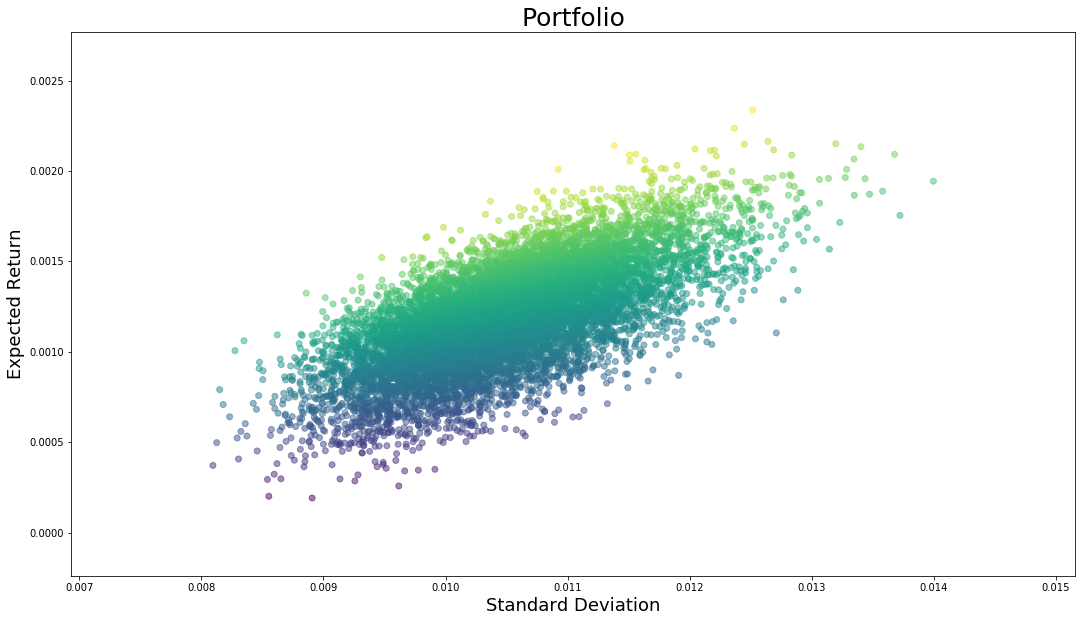

In [15]:
chartData(constraint1_ns,
            objective_ns,
            15,
            0,
            10000)

### 3.2.3 Efficient Frontier, Shorting Allowed

Similarly, the efficient frontier is represented with light-green to yellow colors, lying on the top-left side of the diagram. It is clearly visible that the diagram is focused to approximately 0.7 standard deviation with zero expected return and dispersing from the point of focus. Accumulation is caused by selecting normally distributed simulation input. Since negative weigths are allowed in shorting allowed case, it is evident that some of the simulated portfolios are yielding losses. Additionally negative weigths allow the model a broader selection of weights enabling the model to reduce the risk further.

When comparing shorting allowed case with no-shorting allowed case, it is important to consider that axis boundaries of both of the charts are different for their individual visibility. As markowitz theorem states, shorting allowed portfolio covers a larger area in both expected return and variance due to wider selection of weights, producing values that are more than two times of expected return of maximums of no-shorting allowed portfolio.

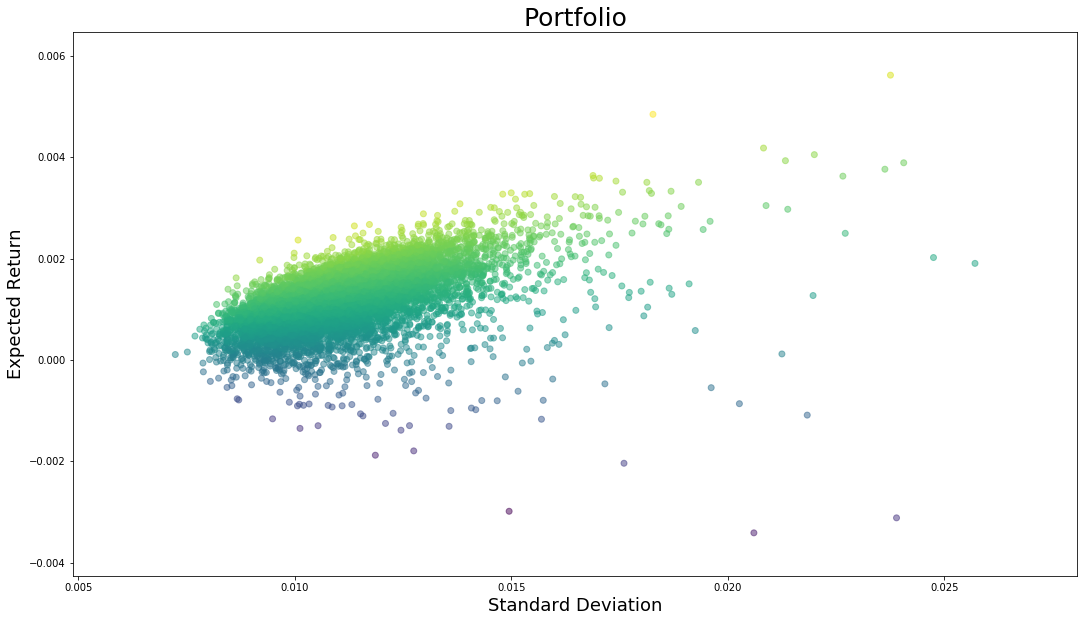

In [16]:
chartData(constraint1_ns,
            objective_ns,
            15,
            1,
            10000)

## 3.3 Solutions

### 3.3.1 Shorting Not Allowed, Quadratic Solution


In order to achieve minimum possible variance, the variance summation formula is tried to be minimized. 

$$ \sum_{i,j=1}^{n}w_{i}w_{j}σ_{ij} $$ 

By providing equation below, which imposes the boundaries for the sum of the weights to the optimizer.

$$ (\sum_{i=1}^{n}w_{i}) - 1 = 0  $$


SLSQP method for the optimized is used for minimizing the variance with all variables within (0,1) bound. Since mean proportional weighter portfolio of  2. Example portfolios section was superior for expected return, its weights are used as the initial weigths for the optimizer in order to provide a fresh start. Weigths for the optimal solution is represented as sol.x and the variance for the optimal weigths as sol.fun.



In [17]:
b = (0.0,1.0)
variable_bounds = ( b,b,b,b,b,b,b,b,b,b,b,b,b,b,b )
con2 = {'type':'eq', 'fun':constraint2_ns} 
sol = minimize(objective_ns,
               initial_weigths,
               method="SLSQP",
               bounds=variable_bounds,
               constraints=con2,
               options = {"nfev":2000, "eps":0.5}
              )

#weights are stored for 5.CAPM section
ns_solution_set = sol.x
sol

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: OptimizeWarning: Unknown solver options: nfev
  if __name__ == '__main__':


     fun: 5.8314189746053164e-05
     jac: array([2.28686349e-04, 2.22083520e-04, 2.23953897e-04, 2.50460186e-04,
       3.29040458e-04, 5.86447282e-04, 6.58170517e-04, 3.38822721e-04,
       2.77610501e-04, 3.61916971e-04, 1.97075509e-04, 3.91894473e-04,
       3.13160807e-04, 8.30922986e-05, 1.47761809e-04])
 message: 'Optimization terminated successfully.'
    nfev: 136
     nit: 8
    njev: 8
  status: 0
 success: True
       x: array([1.39088786e-01, 1.23190374e-01, 2.28494682e-02, 6.74717505e-02,
       2.86464916e-02, 3.38601212e-03, 0.00000000e+00, 1.73472348e-18,
       1.11145429e-01, 0.00000000e+00, 1.09232125e-01, 4.19880993e-02,
       5.43203566e-02, 1.59133234e-01, 1.39547875e-01])

Optimizer terminated successfully after finding a possible global minimum. This can be further supported by observing the standard deviation in simulation charts. Sum of weigths are printed in order to measure optimizers validity. Individual weigths and statistics regarding the optimal solution can be seen below.

In [18]:
print("Minimum Variance: ", sol.fun)
print("Minimum standard deviation: ", np.sqrt( objective_ns(sol.x) ))
print("Expected daily return: %", 100*constraint1_ns(sol.x))
print("Expected weekly return: %", 100*5*constraint1_ns(sol.x))
print("Sum of weigths: ", np.sum( sol.x ) )
Weigths = pd.DataFrame( {"Value":sol.x} )
Weigths.index.rename("Weigth No", inplace=True)
print("Maximum weigth is of Weigth No: ",
      Weigths["Value"][Weigths["Value"] == max(Weigths.Value)].index[0],
      "and has a value of:",
      max(Weigths.Value) )
print("Minimum weigth is of Weigth No: ",
      Weigths["Value"][Weigths["Value"] == min(Weigths.Value)].index[0],
      "and has a value of:",
      min(Weigths.Value) )
Weigths.transpose()

Minimum Variance:  5.8314189746053164e-05
Minimum standard deviation:  0.007636372813453594
Expected daily return: % 0.057383650589825544
Expected weekly return: % 0.2869182529491277
Sum of weigths:  1.0000000000000002
Maximum weigth is of Weigth No:  13 and has a value of: 0.1591332342131087
Minimum weigth is of Weigth No:  6 and has a value of: 0.0


Weigth No,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
Value,0.139089,0.12319,0.022849,0.067472,0.028646,0.003386,0.0,1.734723e-18,0.111145,0.0,0.109232,0.041988,0.05432,0.159133,0.139548


### 3.3.2 Shorting Allowed, Algebraic Solution

Original formulation proposed for solving the shorting allowed case is as follows.

$$ \sum_{j=1}^{n}w_{j}*σ{ij} - λṝ{i} - µ = 0;  for ∀i $$ 

To practically find a solution, λ=0 and µ=1 can be assumed. However, this will lead violation of the sum of weigths constraint. Therefore, weigths have to be scaled after calculations due to this assumption. With the asumption, the solution equation turns into the following matrix multiplication format, thus enabling linear algebraic solutions.

$$ σ*v - 1 = 0 $$

where v matrix represent unadjusted weigths.

$$  v_{i} = λ*w_{i} $$

With this equation simplification, the optimizer is coded to minimize the sum of mean square error deviations of each individual element that is contained in σv - 1 matrix, from 0 by adjusting v values.

In [19]:
initial_weigths = list(example_portfolios.loc["Weigths, Mean",:].values)
def objective_s( initial_weigths ):
    ms = 0
    for i in np.dot( covariance_matrix.values, initial_weigths ) - np.ones( len(initial_weigths) ):
        ms = ms + (i**2)/len(initial_weigths)
    return ms

def constraint2_s(initial_weigths):
    return (1-np.sum(initial_weigths))


Comes out, the model was able to decrease the MSE value to almost zero, finding the optimal solution.

Since the weights are going to be scaled after the calculations, no bounds are imposed for the inputs. sol.x output represents the unadjusted weights. It is visible that the optimizer found a set of inputs that has almost zero risk, that can be seen as sol.fun.

In [20]:
b = (-9999999, 9999999)
variable_bounds = ( b,b,b,b,b,b,b,b,b,b,b,b,b,b,b )
con2 = {'type':'eq', 'fun':constraint2_ns} 
sol = minimize(objective_s,
               initial_weigths,
               method="TNC",
               bounds=variable_bounds,
               options = {"maxiter":200000, "eps":0.3}
              )
print( "Mean square error: ", sol.fun)
print( "Un-adjusted weigths: \n", sol.x )

Mean square error:  3.506795146915208e-08
Un-adjusted weigths: 
 [ 1892.14709515  1771.48064313  5318.26977813  -128.0992491
   504.39149425  2022.9239539  -2156.51448594  -765.81220875
  2582.70227376  -912.19659029  2833.70844771  2344.55860464
 -2248.05138175 26619.55241339 -8613.14974995]


Un-adjusted solution set is adjusted twice to obtain a weigth interval between (-1,1) and sum of 1. To validate calculations, sum of weigths is printed along with return rates, variances and adjusted weigths.

In [21]:
#un-adjusted solution set
solution_set = sol.x

# (-1,1) scaled solution set
scaler = MinMaxScaler(feature_range=(-1, 1))
solution_set = pd.DataFrame({
    "vi":list(solution_set)
})
solution_set = scaler.fit_transform(solution_set)

#then scaled again to obtain sum of 1
solution_set = solution_set/np.sum(solution_set)

print("Minimum variance: ", objective_ns(solution_set)[0])
print("Minimum standard deviation: ", np.sqrt(objective_ns(solution_set)[0]))
print("Expected daily return: %", 100*constraint1_ns(solution_set.T)[0])
print("Expected weekly return: %", 5*100*constraint1_ns(solution_set.T)[0])
print("Sum of weigths: ", sum(solution_set)[0])
print("Adjusted weigths: \n", solution_set.T[0])


Minimum variance:  0.00015574961630808936
Minimum standard deviation:  0.012479968602047416
Expected daily return: % 0.01583695188620056
Expected weekly return: % 0.07918475943100281
Sum of weigths:  0.9999999999999998
Adjusted weigths: 
 [ 0.06838729  0.06954774  0.03543813  0.08781607  0.08173339  0.0671296
  0.10732342  0.09394898  0.06174619  0.09535677  0.05933225  0.06403643
  0.10820374 -0.16941714  0.16941714]


## 3.4 Comparison of Solutions

The assets are expected to increase in value over time. Therefore, short selling of an asset for the entire investment period duration must be definintely refrained. If the market makers allow short selling, short selling of suggested assets by the model should be excercised at right times which can be foreseen by following the news that are capable of effecting the market or the asset.

Theoretically, model with shorting allowed had to provide lower variance for the optimal solution. It is both solved by the algebraic approach and the optimizer package but did not yield a better solution compared to the case where shorting is not allowed. In both tries, algebraic approach produced better results but still unable to beat the optimal solution of shorting not allowed case. This implies that stronger optimization tools are necessary for these types of problems. The solution where shorting is not allowed is superior.



## 4. One-fund theorem

### 4.1 Algebraic Model

Original formulation of one fund theorem is as follows
$$ \sum_{i=1}^{n}(σki  *  v_{i}) = ṝ{k} - ṝ{f};  for ∀k $$ 
$$  Where,   v_{i} = λw_{i} $$

In matrix form, the equation can be expressed as;
$$ σ  *  v_{i} = ṝ - r_{f}$$ 

So that v matrix can be obtained by following linear algebraic solution
$$   v_{i} = σ^{-1}*(ṝ - r_{f})$$ 

Then v values are scaled in order to obtain individual weigths.

In [22]:
#risk free rates yearly to daily
r = 0.062/52/5 #inflation
treasury_rate = 0.0031/52/5 #one year t-bill

#Linear algebraic solution for Eq6.10 pg168
vi_matrix = np.linalg.inv(covariance_matrix.values).dot(example_portfolios.loc["Mean",:].values-treasury_rate)

#scaling lambda*wi between -1,+1
scaler = MinMaxScaler(feature_range=(-1, 1))
vi_df = pd.DataFrame({
    "vi":list(vi_matrix)
})
vi_matrix = scaler.fit_transform(vi_df)

#scaling again so that the sum is 1
vi_matrix = vi_matrix / sum(vi_matrix)

print("Sum of weigths: ", sum(vi_matrix)[0])
print("Risk free daily return rate: ", r)
print("Expected daily return of optimal portfolio for combination with risk free asset: %",100*constraint1_ns(vi_matrix)[0])
print("Expected weekly return of optimal portfolio for combination with risk free asset: %",5*100*constraint1_ns(vi_matrix)[0])
print("Optimal portfolio weigths for inclusion of the risk free asset of daily rate:",treasury_rate,
      "\n", vi_matrix.T[0])


Sum of weigths:  1.0000000000000002
Risk free daily return rate:  0.00023846153846153847
Expected daily return of optimal portfolio for combination with risk free asset: % 0.2648655879822858
Expected weekly return of optimal portfolio for combination with risk free asset: % 1.3243279399114292
Optimal portfolio weigths for inclusion of the risk free asset of daily rate: 1.1923076923076923e-05 
 [ 0.17903866  0.13584595 -0.02963109  0.07296854  0.01990473  0.10729277
  0.08860732 -0.0988076   0.15637424  0.07551699  0.1293949   0.13242048
  0.03107411  0.20745546 -0.20745546]


### 4.2 Expected Return

Risk free rate is lower than the portfolio mean return rate, therefore the expected return steadily decreases proportional to inclusion percentage of risk free asset. The line is linear because expected return rates are included without considering deviations and risks.

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  


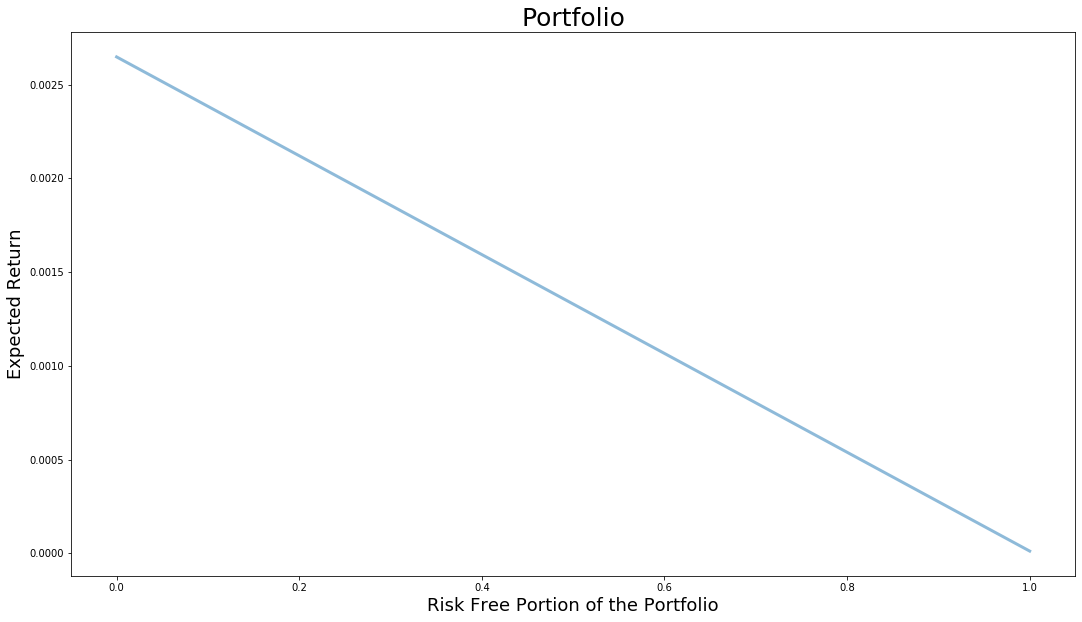

In [23]:
alpha=[] #risk free rate ratio of the portfolio
response=[]
prob=[] #Probability of appreciating more than the risk free rate
#inf = 0.062 #inflation
for i in np.linspace(0.0,1.0,110):
    alpha.append(i)
    response.append( treasury_rate*i + (1-i)*constraint1_ns(vi_matrix) )
    prob.append(st.norm.cdf( 1 -( i*treasury_rate/((1-i)*objective_ns(vi_matrix)))))
    
plt.figure(figsize = (18,10))
plt.plot( alpha,
         response,
         alpha=0.5,
        linewidth=3)
plt.title("Portfolio", fontsize=25)
plt.xlabel("Risk Free Portion of the Portfolio", fontsize=18)
plt.ylabel("Expected Return", fontsize=18)
plt.show()


### 4.3 Probabilities

US interests are stable and low for over recent twenty years. Stocks usually yield more than bonds in US economy. Therefore, the portfolio without a risk free asset almost certainly outperform the risk free rate and the probability of outperforming decreases by inclusion of more risk free asset.

US 1 year treasury bond daily rate:  1.1923076923076923e-05


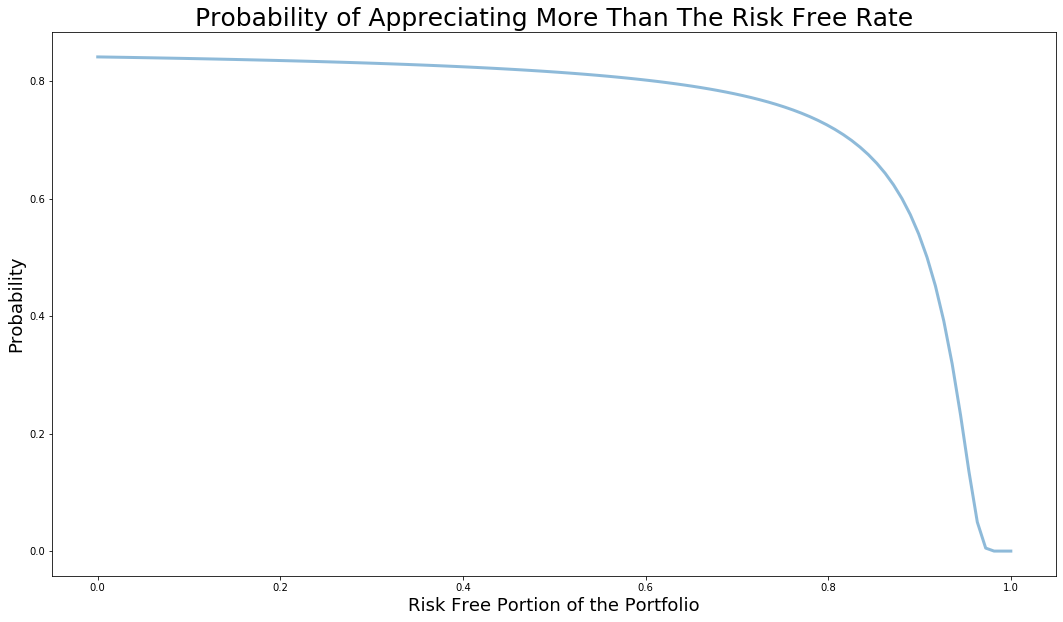

In [24]:
print( "US 1 year treasury bond daily rate: ", treasury_rate )
plt.figure(figsize = (18,10))
plt.plot( alpha,
        prob,
        alpha=0.5,
        linewidth=3)
plt.title("Probability of Appreciating More Than The Risk Free Rate", fontsize=25)
plt.xlabel("Risk Free Portion of the Portfolio", fontsize=18)
plt.ylabel("Probability", fontsize=18)
plt.show()

Covid pandemic resulted inflation spikes in US economy which is ahead of the increase in interest rates. Therefore, the chart demonstrates a similiar view with the chart above. However, the inflation rate is higher than treasury bonds, so even less inclusion of risk free assets may cripple portfolios ability to outperform the inflation.

US 1 year inflation  daily rate:  0.00023846153846153847


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


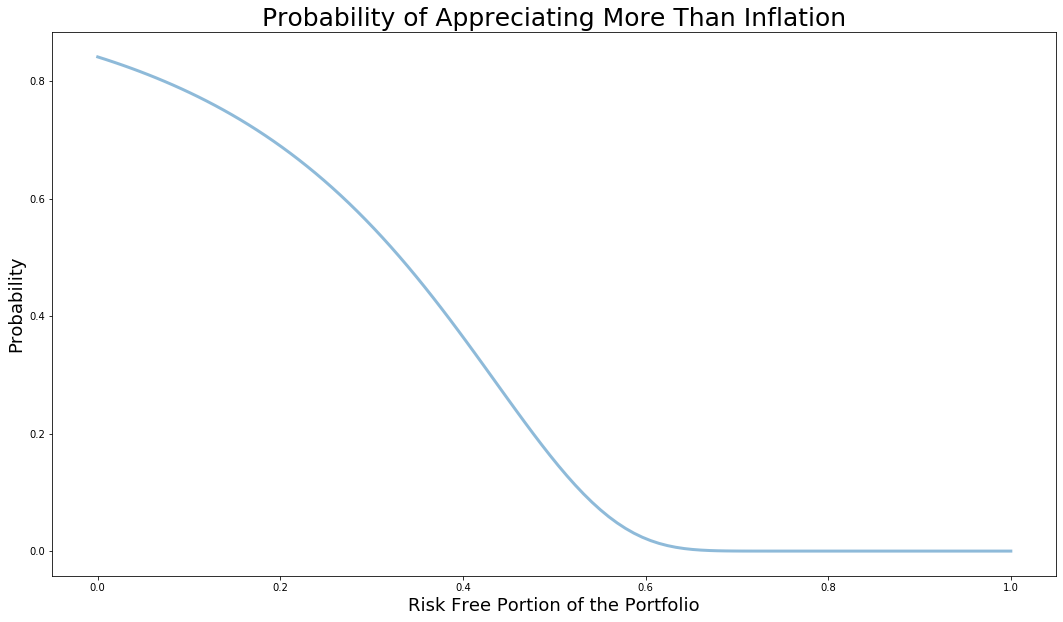

In [25]:
print( "US 1 year inflation  daily rate: ", r )

alpha=[] #risk free rate ratio of the portfolio
response=[]
prob=[] #Probability of appreciating more than the risk free rate
#inf = 0.062 #inflation
for i in np.linspace(0.0,1.0,110):
    alpha.append(i)
    response.append( r*i + (1-i)*constraint1_ns(vi_matrix) )
    prob.append(st.norm.cdf( 1 -( i*r/((1-i)*objective_ns(vi_matrix)))))
    
plt.figure(figsize = (18,10))
plt.plot( alpha,
        prob,
        alpha=0.5,
        linewidth=3)
plt.title("Probability of Appreciating More Than Inflation", fontsize=25)
plt.xlabel("Risk Free Portion of the Portfolio", fontsize=18)
plt.ylabel("Probability", fontsize=18)
plt.show()

## 5. CAPM Model

### 5.1 Assumed Market Portfolio

For this section, it is arbitrarily assumed that the optiomal minimum variance portfolio for the shorting not allowed case is the market portfolio.

#### 5.1.1 Capital Market Line

Capital market line is drawn with the simulation inputs. Validity of the capital market line can be verified by 3 ways; expected return increases with additional risks beared, capital market line passes through the simulated points and the assumed market portfolio.

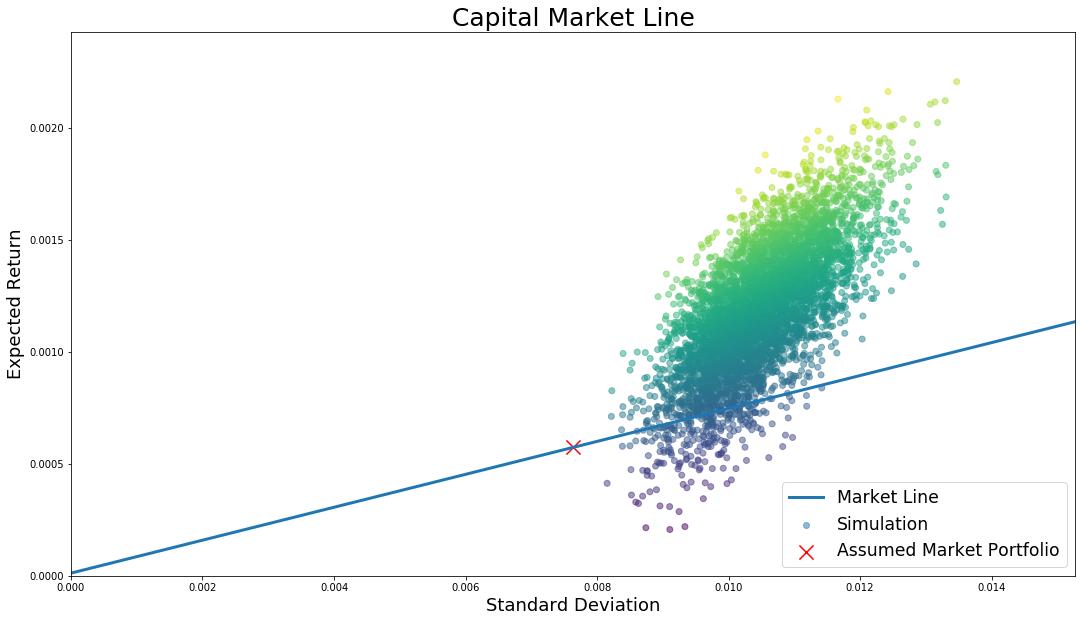

In [26]:
# assuming optimal sol for no shorting is the cap

#market portfolio return
rM = constraint1_ns( ns_solution_set )

#one year t-bill
treasury_rate = 0.0031/52/5

#plots market line
plt.figure(figsize = (18,10))
plt.plot( [0,np.sqrt(objective_ns( ns_solution_set )),2*np.sqrt(objective_ns( ns_solution_set )) ],
        [treasury_rate, constraint1_ns( ns_solution_set ), 2*(constraint1_ns( ns_solution_set )-treasury_rate)+treasury_rate ],
        linewidth=3,
        label="Market Line")

#simulated data points
X=[] #std
Y=[] #return
for i in range (5000):
        
    #random feasible weigths
    rand = np.random.rand(15,1)
    rand = list( rand/np.sum(rand) )
        
    X.append( np.sqrt(objective_ns( rand )) )
    Y.append( constraint1_ns( rand ) )
        
        
#plots the simulated data points in a relatively visible size    
plt.scatter( X, Y,
            c = (np.array(Y)*(1/np.array(X))),
            alpha=0.5,
            marker="o",
            label="Simulation")

#plots no-shorting minimum variance portfolio
plt.scatter(np.sqrt(objective_ns(ns_solution_set)),
            constraint1_ns(ns_solution_set),
            marker = "x",
            s=200,
            color="red",
            label="Assumed Market Portfolio")

#chart limits
plt.xlim(0, 2*np.sqrt(objective_ns( ns_solution_set )))
plt.ylim(0, 1.1*max(Y))

#chart attributes
plt.title("Capital Market Line", fontsize=25)
plt.xlabel("Standard Deviation", fontsize=18)
plt.ylabel("Expected Return", fontsize=18)
plt.legend( loc=4, fontsize="xx-large" )
plt.show()

#### 5.1.2 Price of Risk

Price of risk refers to slope of the the market line. In this example, roughly 0.73 increase in expected return rate can be expected for each unit increase in standard deviation.

In [27]:
#price of risk; slope of capm line
riskPrice = (constraint1_ns( ns_solution_set ) - treasury_rate) / np.sqrt(objective_ns( ns_solution_set ))
print("Price of risk: ", riskPrice)

Price of risk:  0.07358381298320216


#### 5.1.3 Beta Values

Beta values of individual assets are calculated by this equation.
$$  β_{i}= \dfrac{ \bar{r_{i}} - r_{f} }{ \bar{r_{M}} - r_{f} } $$ 


In [28]:
beta = []
for col in example_portfolios.columns.values:
    beta.append( (example_portfolios.loc["Mean",col] - treasury_rate) / (rM - treasury_rate) )

#for col in example_portfolios.columns.values:
#    beta.append( changeData[col].cov( spxData["Change"] ) / np.var(spxData["Change"]) )


betaDf = pd.DataFrame({
    "Stock": list(example_portfolios.columns.values),
    "Beta" : beta
})

betaDf.set_index("Stock", inplace=True)
betaDf = betaDf.T
betaDf

Stock,AAPL,MSFT,AMZN,GOOGL,FB,TSLA,NVDA,ADBE,NFLX,CRM,CSCO,QCOM,INTC,VZ,T
Beta,4.100011,3.651931,0.675092,1.948063,-1.409967,7.93181,8.627959,1.177753,3.548274,2.056309,1.352967,4.660316,-0.99805,-1.906995,-3.824054


If a bull market is expected, stocks which are listed below having positive beta values should be preffered in order to beat the market. However, beta values should not be the sole criteria for evaluation. Beta values should be evaluated in company with standard deviation values of corresponding assets.

In [29]:
betaDf.loc[:,betaDf.loc["Beta",:] > 0]

Stock,AAPL,MSFT,AMZN,GOOGL,TSLA,NVDA,ADBE,NFLX,CRM,CSCO,QCOM
Beta,4.100011,3.651931,0.675092,1.948063,7.93181,8.627959,1.177753,3.548274,2.056309,1.352967,4.660316


Negative beta value of an asset imply its tendency to have an opposite tred to the market. Assets with negative beta values should be preffered in bear market or they can be preffered to compansate lossess during regular market trends.They are listed below

In [30]:
betaDf.loc[:,betaDf.loc["Beta",:] < 0]

Stock,FB,INTC,VZ,T
Beta,-1.409967,-0.99805,-1.906995,-3.824054


$$ β_{p} = \sum_{i=1}^{n}w_{i}β{i}  $$ 

Beta value of 1, of the portfolio further validates the calculations because the market portfolios beta must be equal to one.


In [31]:
#without inclusion of risk free asset
portfolioBeta = 0
for i in range( len(ns_solution_set) ):
    portfolioBeta += ns_solution_set[i]*betaDf.values[0][i]

portfolioBeta

1.0000000000000004

#### 5.1.4 Security Market Line

Security market line is drawn below. Since the market portfolio is assumed to be the optimal minimum variance portfolio of no shorting case, market porfolio point shall represent them both.

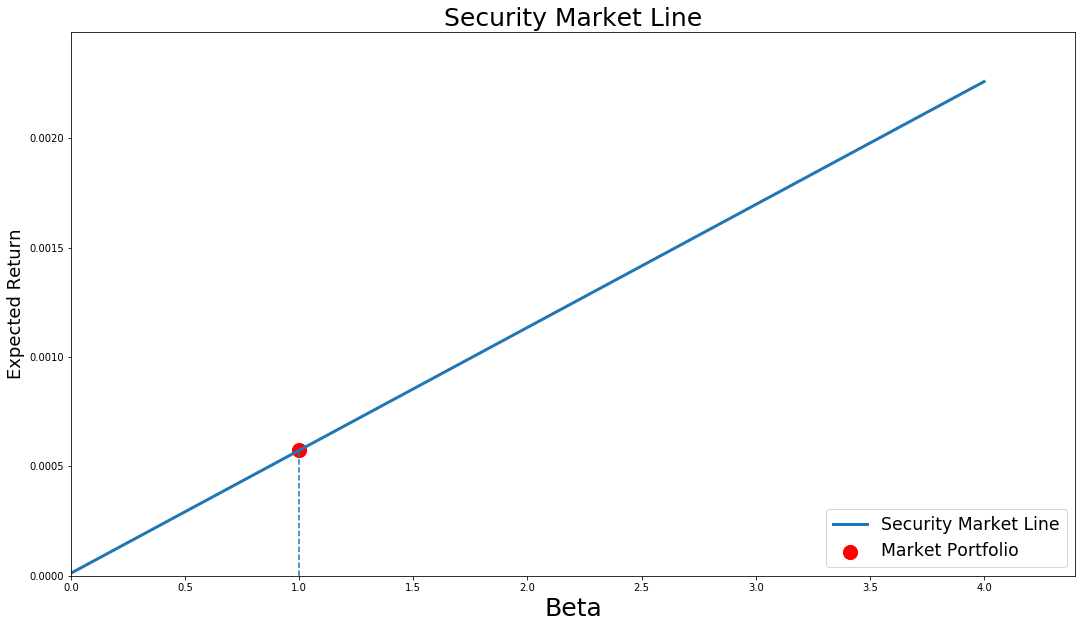

In [32]:
#plot attributes
plt.figure( figsize=(18,10) )
plt.title("Security Market Line", fontsize=25)
plt.xlabel("Beta", fontsize=25)
plt.ylabel("Expected Return", fontsize=18)

#sml plot
plt.plot([0,1,4],
        [treasury_rate, rM, 4*(rM-treasury_rate)+treasury_rate],
        linewidth=3,
        label="Security Market Line")

#dashed line
plt.axvline(x=portfolioBeta,  ymin=0, ymax=rM/(1.1*(4*(rM-treasury_rate)+treasury_rate)), linestyle="--")

#market portfolio
plt.scatter(portfolioBeta,
           rM,
           marker="o",
           s=200,
           color="red",
           label="Market Portfolio")

#plot limits
plt.xlim( 0, 4*1.1 )
plt.ylim( 0, 1.1*(4*(rM-treasury_rate)+treasury_rate) )
plt.legend( loc=4, fontsize="xx-large" )
plt.show()

### 5.2 S&P500 Index as the Market Portfolio

#### 5.2.1 S&P500 Data

S&P 500 index has been chosen as the market portfolio since it possesses variation of all assets in the market. Index data is obtained from the identical source and for same given dates. Daily change data is calculated and data is aggregated.

In [33]:
#spx value data
spxDf = pd.read_csv( os.path.expanduser("~/Desktop/Belgeler/BOUN/Dersler/ETM595 RISK/PJ/Solo/spx.csv") )
spxDf = spxDf.loc[:,"Close"]
spxDf = spxDf.apply(objectToInt)

#spx change data
spxChange = []
for i in range(spxDf.shape[0]-1):
    spxChange.append( (spxDf.iloc[i] - spxDf.iloc[i+1])/spxDf.iloc[i+1]  )

#aggregating spx data
spxData = pd.DataFrame({
    "Close":spxDf[:90],
    "Change":spxChange[:90]
})

spxR = spxData.describe().loc["mean","Change"]
spxStd = spxData.describe().loc["std","Change"]
print( "S&P500 Mean daily return:", spxR )
print( "S&P500 std of daily returns:", spxStd )
spxData.head()

S&P500 Mean daily return: 0.000785193653515881
S&P500 std of daily returns: 0.00783022762638712


,Close,Change
0,4712.02,0.009549
1,4667.45,-0.007181
2,4701.21,0.003085
3,4686.75,0.020707
4,4591.67,0.011731


#### 5.2.2 Capital Market Line

In the following graph, market line of S&P500 and assumed market line in section 5.1 is drawn together for better comparison. It is visible that S&P500 market line is more suitable for being a market line candidate because it centralizes the simulated portfolios. Price of risk of S&P500 market line is roughly %34 greater than price of risk of assumed market line. This implies that most of the assets in S&P500 market have had better yields when compared to stocks that are being analyzed, within the same period. Therefore, it can be expected that better returns per risk can be obtained by a portfolio formed with assets that are currently not being analyzed. 

Price of risk of S&P 500 market line:  0.09875454629019417


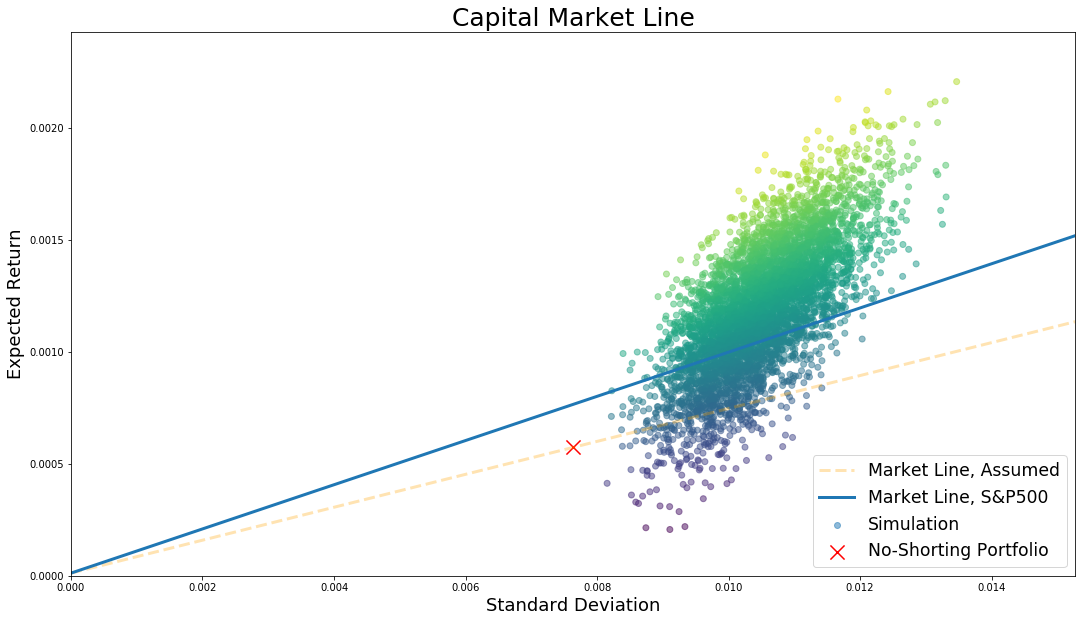

In [34]:

#market portfolio return
#rSP500 = constraint1_ns( ns_solution_set )

#price of risk of sp500 market line
sp500RiskPrice = (spxR - treasury_rate)/spxStd
print( "Price of risk of S&P 500 market line: ", sp500RiskPrice )

#market line with assumption, of 5.1.1
plt.figure(figsize = (18,10))
plt.plot( [0,np.sqrt(objective_ns( ns_solution_set )),2*np.sqrt(objective_ns( ns_solution_set )) ],
        [treasury_rate, constraint1_ns( ns_solution_set ), 2*(constraint1_ns( ns_solution_set )-treasury_rate)+treasury_rate ],
        linewidth=3,
        label="Market Line, Assumed",
        linestyle="--",
        alpha=0.3,
        color="orange")

#plots market line
plt.plot( [0,spxStd,2*spxStd ],
        [treasury_rate, spxR, 2*(spxR-treasury_rate)+treasury_rate ],
        linewidth=3,
        label="Market Line, S&P500")
        
        
#plots the same simulated data points of 5.1.1    
plt.scatter( X, Y,
            c = (np.array(Y)*(1/np.array(X))),
            alpha=0.5,
            marker="o",
            label="Simulation")

#plots no-shorting minimum variance portfolio
plt.scatter(np.sqrt(objective_ns(ns_solution_set)),
            constraint1_ns(ns_solution_set),
            marker = "x",
            s=200,
            color="red",
            label="No-Shorting Portfolio")

#chart limits
plt.xlim(0, 2*np.sqrt(objective_ns( ns_solution_set )))
plt.ylim(0, 1.1*max(Y))

#chart attributes
plt.title("Capital Market Line", fontsize=25)
plt.xlabel("Standard Deviation", fontsize=18)
plt.ylabel("Expected Return", fontsize=18)
plt.legend( loc=4, fontsize="xx-large" )
plt.show()

#### 5.2.3 Beta Values


Beta values are calculated with the provided formula.
$$  β_{i}= \dfrac{σ_{iM}}{σ^2_{M}} $$

Since all assets have positive beta values, they are inclined to follow the market trend. It would be better to insure the portfolio by including assets with negative values but in this case stocks with smaller beta values can be used to compensate the lossess if the market is down-trending. However, it will be better to use S&P500 stocks with negative values that are not included in the current analysis.

In [35]:
#calculating beta values
beta = []
for col in example_portfolios.columns.values:
    beta.append( changeData[col].cov( spxData["Change"] ) / np.var(spxData["Change"]) )

#aggregating data
betaDf = pd.DataFrame({
    "Stock": list(example_portfolios.columns.values),
    "Beta" : beta
})

#display
betaDf.set_index("Stock", inplace=True)
betaDf = betaDf.T
betaDf


Stock,AAPL,MSFT,AMZN,GOOGL,FB,TSLA,NVDA,ADBE,NFLX,CRM,CSCO,QCOM,INTC,VZ,T
Beta,1.131273,1.141742,1.119619,1.21432,1.32148,1.226587,2.292274,1.56676,0.834394,1.429799,0.810625,1.425456,1.127397,0.308426,0.595111


In [36]:
#without inclusion of risk free asset
portfolioBeta = 0
for i in range( len(ns_solution_set) ):
    portfolioBeta += ns_solution_set[i]*betaDf.values[0][i]

print("Portfolio Beta: ", portfolioBeta)

Portfolio Beta:  0.8820283753144993


#### 5.2.4 Security Market Line

All of the assets are not positioned on the security market line. This occurence implies that the market is not as mature as it is hypotheticly presumed in the CAPM theory assumptions.

AAPL, GOOGL and CRM portfolios signify very low non-systematic risk. Therefore risk of those assets are correlated with the market and cannot be further reduced with diversification. However, TSLA and NVDA stocks demonstrate high non-systematic risks with exceptional returns. Those assets should be utilized with proper diversification

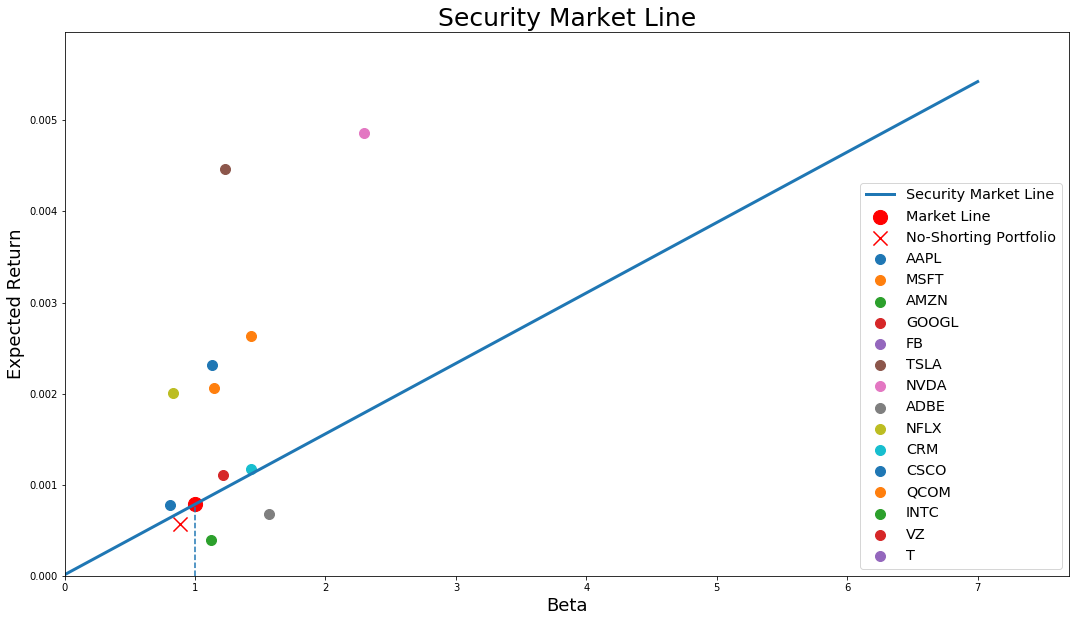

In [37]:
#plot attributes
plt.figure( figsize=(18,10) )
plt.title("Security Market Line", fontsize=25)
plt.xlabel("Beta", fontsize=18)
plt.ylabel("Expected Return", fontsize=18)

#sml plot
plt.plot([0,1,7],
        [treasury_rate, spxR, 7*(spxR-treasury_rate)+treasury_rate],
        linewidth=3,
        label="Security Market Line")

#dashed line
plt.axvline(x=1,  ymin=0, ymax=spxR/(1.1*(7*(spxR-treasury_rate)+treasury_rate)), linestyle="--")

#market portfolio
plt.scatter(1,
           spxR,
           marker="o",
           s=200,
           color="red",
           label="Market Line")

#optimal no shorting portfolio
plt.scatter(portfolioBeta,
           constraint1_ns(ns_solution_set),
           marker="x",
           s=200,
           color="red",
           label="No-Shorting Portfolio")

#individual assets
for i in betaDf.columns.values:
    plt.scatter(betaDf.loc["Beta",i],
           example_portfolios.loc["Mean",i],
           marker="o",
           s=100,
           label=i)

#plot limits
plt.xlim( 0, 7*1.1 )
plt.ylim( 0, 1.1*(7*(spxR-treasury_rate)+treasury_rate) )
plt.legend( loc=4, fontsize="x-large" )
plt.show()

#### 5.2.5 Jensen Index Evaluation

Jensen index implies the deviation of an assets return from security market line, given the same beta. Security market line in the chart above is used for the difference calculations. Indexes of all assets can be seen below.

In [38]:
#jensen index for assets
#sml eq (spxR-treasury_rate)*beta +treasury_rate

#calculation
jensen_index = []
for i in example_portfolios.columns.values:
    jensen_index.append( example_portfolios.loc["Mean",i] \
                        - (spxR-treasury_rate)*betaDf.loc["Beta",i] +treasury_rate )
#aggregation
jensen_index
jensenDf = pd.DataFrame({
    "Stock":example_portfolios.columns.values,
    "Jensen Index":jensen_index
})

#display
jensenDf.set_index("Stock", inplace=True)
jensenDf = jensenDf.T
jensenDf

Stock,AAPL,MSFT,AMZN,GOOGL,FB,TSLA,NVDA,ADBE,NFLX,CRM,CSCO,QCOM,INTC,VZ,T
Jensen Index,0.001453,0.001193,-0.000463,0.000179,-0.00179,0.003532,0.003099,-0.000526,0.001372,0.000074,0.000157,0.00154,-0.001409,-0.001286,-0.002585


Positive Jensen Index implies that the corresponding stocks yielded better than CAPM predcition. They are listed below.

In [39]:
jensenDf.loc[:,jensenDf.loc["Jensen Index",:] > 0]

Stock,AAPL,MSFT,GOOGL,TSLA,NVDA,NFLX,CRM,CSCO,QCOM
Jensen Index,0.001453,0.001193,0.000179,0.003532,0.003099,0.001372,0.000074,0.000157,0.00154


Similarly, negative Jensen Index values imply that the assets performance was worse than the market prediction. They are listed below.

In [40]:
jensenDf.loc[:,jensenDf.loc["Jensen Index",:] < 0]

Stock,AMZN,FB,ADBE,INTC,VZ,T
Jensen Index,-0.000463,-0.00179,-0.000526,-0.001409,-0.001286,-0.002585


Jensen Index of the master asset is sligthly lesser than the CAPM prediction, therefore no-shorting allowed minimum variance portfolio yielded a neglectable loss compared to CAPM prediction. Jensen Index of the portfolio shows that the portfolio is barely a good asset.

In [41]:
#jensen index of the portfolio
print("Jensen Index of the portfolio: ",
      constraint1_ns(ns_solution_set) - (spxR-treasury_rate)*portfolioBeta +treasury_rate)


Jensen Index of the portfolio:  -9.628700752932461e-05


#### 5.2.5 Sharpe Index Evaluation

Sharpe Index implies efficiency of the given asset, it is calculated by dividing expected return of an asset beyond the risk free rate to its standard deviation hence, it can be interpreted as expected return beyond risk free rate of per unit risk taken. Since the denominator is standard deviation rather than beta, it will be visually coherent return-std version of the security market line in this context which is displayed below.

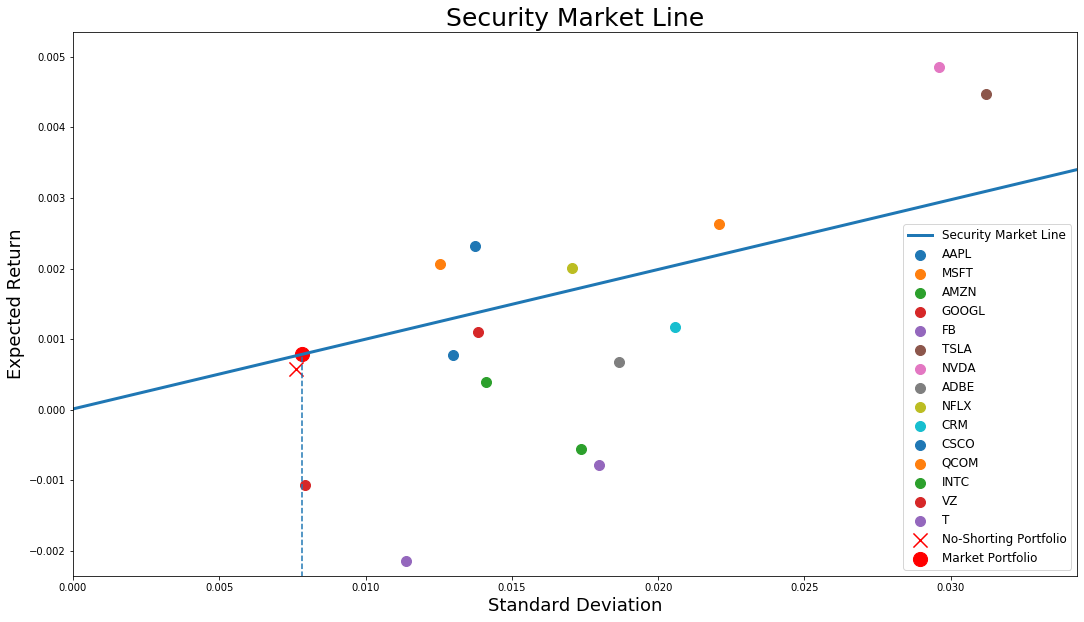

In [42]:

#plot properties
plt.figure( figsize=(18,10) )
plt.title("Security Market Line", fontsize=25)
plt.xlabel("Standard Deviation", fontsize=18)
plt.ylabel("Expected Return", fontsize=18)

#security market line
plt.plot([0, spxStd, 50*spxStd],
        [treasury_rate, spxR, 50*(spxR-treasury_rate)+treasury_rate ],
        linewidth=3,
        label="Security Market Line")

#dashed line
plt.axvline(x=spxStd,
            ymin=1.1*min(example_portfolios.loc["Mean",:].values),
            ymax=(spxR-1.1*min(example_portfolios.loc["Mean",:]))/(1.1*max(example_portfolios.loc["Mean",:].values)-1.1*min(example_portfolios.loc["Mean",:].values)),
            linestyle="--")

#individual assets
for i in example_portfolios.columns.values:
    plt.scatter(np.sqrt( example_portfolios.loc["Variance",i] ),
           example_portfolios.loc["Mean",i],
           s=100,
           label=i)

#no shorting portfolio
plt.scatter(np.sqrt(objective_ns(ns_solution_set)),
           constraint1_ns(ns_solution_set),
           marker="x",
           s=200,
           color="red",
           label="No-Shorting Portfolio")

#market portfolio
plt.scatter(spxStd,
            spxR,
           s=200,
           marker="o",
           color="red",
           label="Market Portfolio")

#plot limits
plt.xlim( 0, max(np.sqrt( example_portfolios.loc["Variance",:].values ))*1.1 )
plt.ylim( 1.1*min(example_portfolios.loc["Mean",:].values), 1.1*max(example_portfolios.loc["Mean",:].values) )
plt.legend( loc=4, fontsize="large" )
plt.show()

Sharpe index of each individual asset is calculated below.

In [43]:
#Sharpe index of SML
sharpeSml = (spxR-treasury_rate)/spxStd
print( "Sharpe Index of the SML: ", sharpeSml  )


# sharpe index of assets
#calculation
sharpe_index=[]
for i in example_portfolios.columns.values:
    sharpe_index.append( (example_portfolios.loc["Mean",i] - treasury_rate) / spxStd )

#aggregation
sharpeDf = pd.DataFrame({
    "Stock":example_portfolios.columns.values,
    "Sharpe Index":sharpe_index
})

#display
sharpeDf.set_index("Stock", inplace=True)
sharpeDf = sharpeDf.T
sharpeDf



Sharpe Index of the SML:  0.09875454629019417


Stock,AAPL,MSFT,AMZN,GOOGL,FB,TSLA,NVDA,ADBE,NFLX,CRM,CSCO,QCOM,INTC,VZ,T
Sharpe Index,0.294225,0.26207,0.048446,0.139797,-0.101182,0.569203,0.61916,0.084518,0.254632,0.147565,0.097092,0.334434,-0.071622,-0.13685,-0.274422


Since sharpe index of the security market line is 0.099, assets with higher sharpe index denote that they are more efficient than the market portfolio itself. They are listed below.

In [44]:
sharpeDf.loc[:,sharpeDf.loc["Sharpe Index",:] > sharpeSml]

Stock,AAPL,MSFT,GOOGL,TSLA,NVDA,NFLX,CRM,QCOM
Sharpe Index,0.294225,0.26207,0.139797,0.569203,0.61916,0.254632,0.147565,0.334434


Assets that are less efficient than the the market portfolio listed below.

In [45]:
sharpeDf.loc[:,sharpeDf.loc["Sharpe Index",:] < sharpeSml]

Stock,AMZN,FB,ADBE,CSCO,INTC,VZ,T
Sharpe Index,0.048446,-0.101182,0.084518,0.097092,-0.071622,-0.13685,-0.274422


Sharpe index of the portfolio is slightly less than sharpe index of the market portfolio. This implies that minimum variance optimized no-shorting portfolio is barely inefficient.

In [46]:
#sharpe index of the portfolio
print("Sharpe index of the portfolio: ",
      (constraint1_ns(ns_solution_set) - treasury_rate) / np.sqrt(objective_ns(ns_solution_set)) )

Sharpe index of the portfolio:  0.07358381298320216


### 5.3 Portfolio Evaluation

In first part of the 5. CAPM section, it is assumed that optimal minimum variance no-shorting portfolio is the market portfolio and with further calculation it is proved that such an assumption is wrong. In the latter part of the section, performance of optimal minimum variance no-shorting portfolio is evaluated with respect to main index of its corresponding market S&P 500. For the jensen index evaluation, the portfolio resulted with a slightly negative index. Demonstrating relatively lower market correlation than most of the individual assets, with the ability of compensating the market lossess sligthly better than most of the individual assets. For the sharpe evaluation, the portfolio yielded a positive index value but that is slightly lower than the security market line. Therefore, sharpe index implies that portfolio is not efficient enough in terms of return expected for per unit of risk beared. This concludes that, the optimal minimum variance no-shorting portfolio is relatively moderate within the market. Most probably it would be better to seek alternatives.